In [ ]:
import torch
import numpy as np
import torch.nn as nn
from torch.optim import Adam
import matplotlib.pyplot as plt
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from mpl_toolkits.axes_grid1 import ImageGrid
from torchvision.utils import save_image, make_grid

# Load CIFAR-10 dataset
transform = transforms.Compose([transforms.ToTensor()])  # Resize images to 32x32
path='~/datasets'
train_dataset = CIFAR10(path, transform=transform, download=True)
test_dataset = CIFAR10(path, transform=transform, download=True)

batch_size = 100
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



100%|██████████| 170498071/170498071 [00:13<00:00, 12476090.36it/s]


Extracting /root/datasets/cifar-10-python.tar.gz to /root/datasets
Files already downloaded and verified


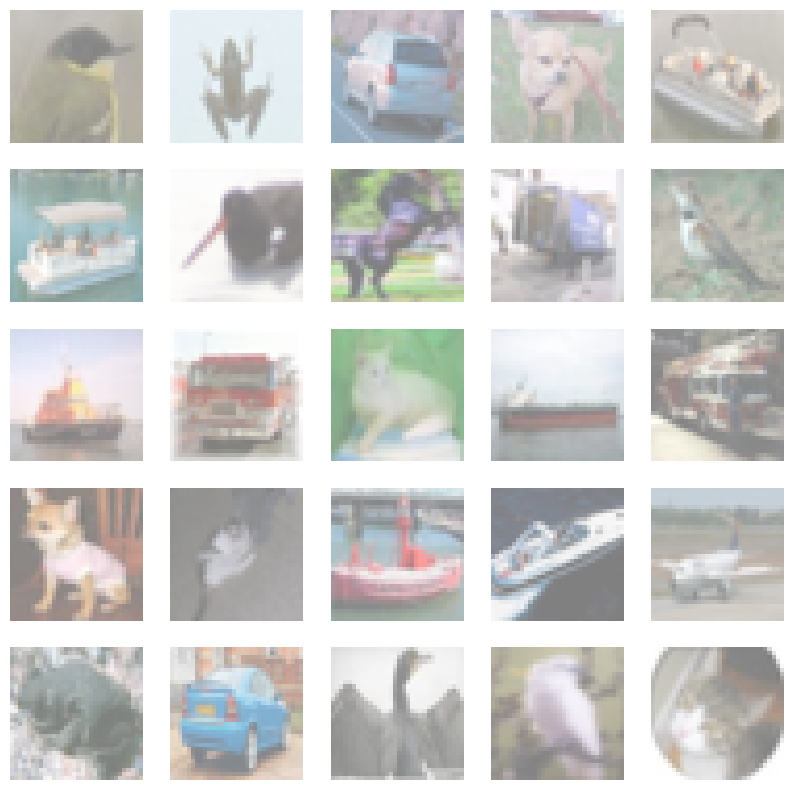

In [ ]:
# Get 25 sample training images for visualization
dataiter = iter(train_loader)
images, _ = next(dataiter)

num_samples = 25
sample_images = images[:num_samples]

# Plot the sample images
fig, axes = plt.subplots(5, 5, figsize=(10, 10))

for i in range(5):
    for j in range(5):
        axes[i, j].imshow(sample_images[i * 5 + j].permute(1, 2, 0) / 2 + 0.5)  # Denormalize and permute dimensions
        axes[i, j].axis('off')

plt.show()


In [ ]:
# Define Encoder using CNN
class Encoder(nn.Module):
    def __init__(self, latent_dim=256):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1)
        self.fc_mean = nn.Linear(256*2*2, latent_dim)
        self.fc_logvar = nn.Linear(256*2*2, latent_dim)
        self.LeakyReLU = nn.LeakyReLU(0.2)

    def forward(self, x):
        x = self.LeakyReLU(self.conv1(x))
        x = self.LeakyReLU(self.conv2(x))
        x = self.LeakyReLU(self.conv3(x))
        x = self.LeakyReLU(self.conv4(x))
        x = x.view(x.size(0), -1)
        mean = self.fc_mean(x)
        logvar = self.fc_logvar(x)
        return mean, logvar




In [ ]:
# Define Decoder using CNN
class Decoder(nn.Module):
    def __init__(self, latent_dim=256):
        super(Decoder, self).__init__()
        self.fc = nn.Linear(latent_dim, 256*2*2)
        self.conv1 = nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1)
        self.conv2 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1)
        self.conv3 = nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1)
        self.conv4 = nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1)
        self.LeakyReLU = nn.LeakyReLU(0.2)

    def forward(self, x):
        x = self.fc(x)
        x = x.view(x.size(0), 256, 2, 2)
        x = self.LeakyReLU(self.conv1(x))
        x = self.LeakyReLU(self.conv2(x))
        x = self.LeakyReLU(self.conv3(x))
        x = torch.sigmoid(self.conv4(x))
        return x


In [ ]:

# Define VAE
class VAE(nn.Module):
    def __init__(self, latent_dim=256):
        super(VAE, self).__init__()
        self.encoder = Encoder(latent_dim)
        self.decoder = Decoder(latent_dim)

    def encode(self, x):
        mean, logvar = self.encoder(x)
        return mean, logvar

    def reparameterize(self, mean, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mean + eps*std

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mean, logvar = self.encode(x)
        z = self.reparameterize(mean, logvar)
        x_recon = self.decode(z)
        return x_recon, mean, logvar






In [ ]:
model = VAE().to(device)
optimizer = Adam(model.parameters(), lr=1e-3)


In [ ]:
# Define loss function
def loss_function(recon_x, x, mu, logvar):
    BCE = nn.functional.binary_cross_entropy(recon_x.view(-1, 32*32*3), x.view(-1, 32*32*3), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

In [ ]:
# Training function
def train(model, optimizer, epochs, device):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for batch_idx, (x, _) in enumerate(train_loader):
            x = x.to(device)
            optimizer.zero_grad()
            recon_batch, mu, logvar = model(x)
            loss = loss_function(recon_batch, x, mu, logvar)
            loss.backward()
            total_loss += loss.item()
            optimizer.step()
        print('Epoch {}, Loss: {:.4f}'.format(epoch+1, total_loss / len(train_loader.dataset)))

# Train the model
train(model, optimizer, epochs=20, device=device)

Epoch 1, Loss: 1928.4560
Epoch 2, Loss: 1854.3188
Epoch 3, Loss: 1841.4809
Epoch 4, Loss: 1836.6440
Epoch 5, Loss: 1832.6273
Epoch 6, Loss: 1829.6389
Epoch 7, Loss: 1827.7157
Epoch 8, Loss: 1826.3330
Epoch 9, Loss: 1825.0706
Epoch 10, Loss: 1824.0266
Epoch 11, Loss: 1823.3028
Epoch 12, Loss: 1822.5277
Epoch 13, Loss: 1822.2029
Epoch 14, Loss: 1821.6796
Epoch 15, Loss: 1821.3833
Epoch 16, Loss: 1820.9948
Epoch 17, Loss: 1820.7656
Epoch 18, Loss: 1820.2582
Epoch 19, Loss: 1819.8286
Epoch 20, Loss: 1819.6649


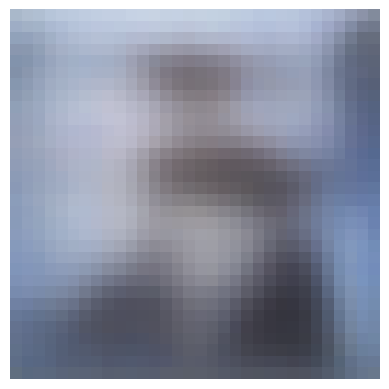

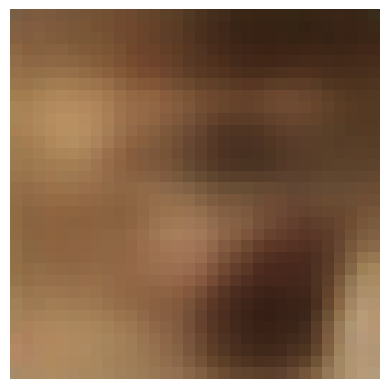

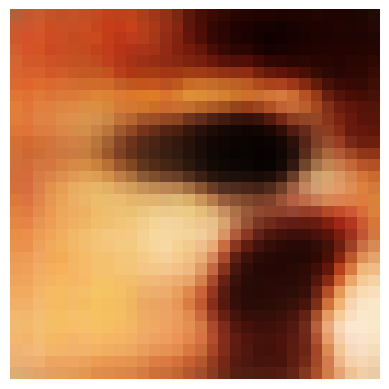

In [ ]:
# Function to generate digit from latent space
def generate_digit(model, mean, var):
    mean = mean.to(device)
    var = var.to(device)
    with torch.no_grad():
        z_sample = torch.randn_like(mean) * var + mean
        x_decoded = model.decoder(z_sample)
    digit = x_decoded.detach().cpu().reshape(3, 32, 32).permute(1, 2, 0)  # Reshape and permute to (32, 32, 3)
    plt.imshow(digit)
    plt.axis('off')
    plt.show()



generate_digit(model, mean=torch.zeros(1, 256).to(device), var=torch.ones(1, 256).to(device))
generate_digit(model, mean=torch.ones(1, 256).to(device), var=torch.zeros(1, 256).to(device))
generate_digit(model, mean=torch.full((1, 256), 2.0).to(device), var=torch.ones(1, 256).to(device))



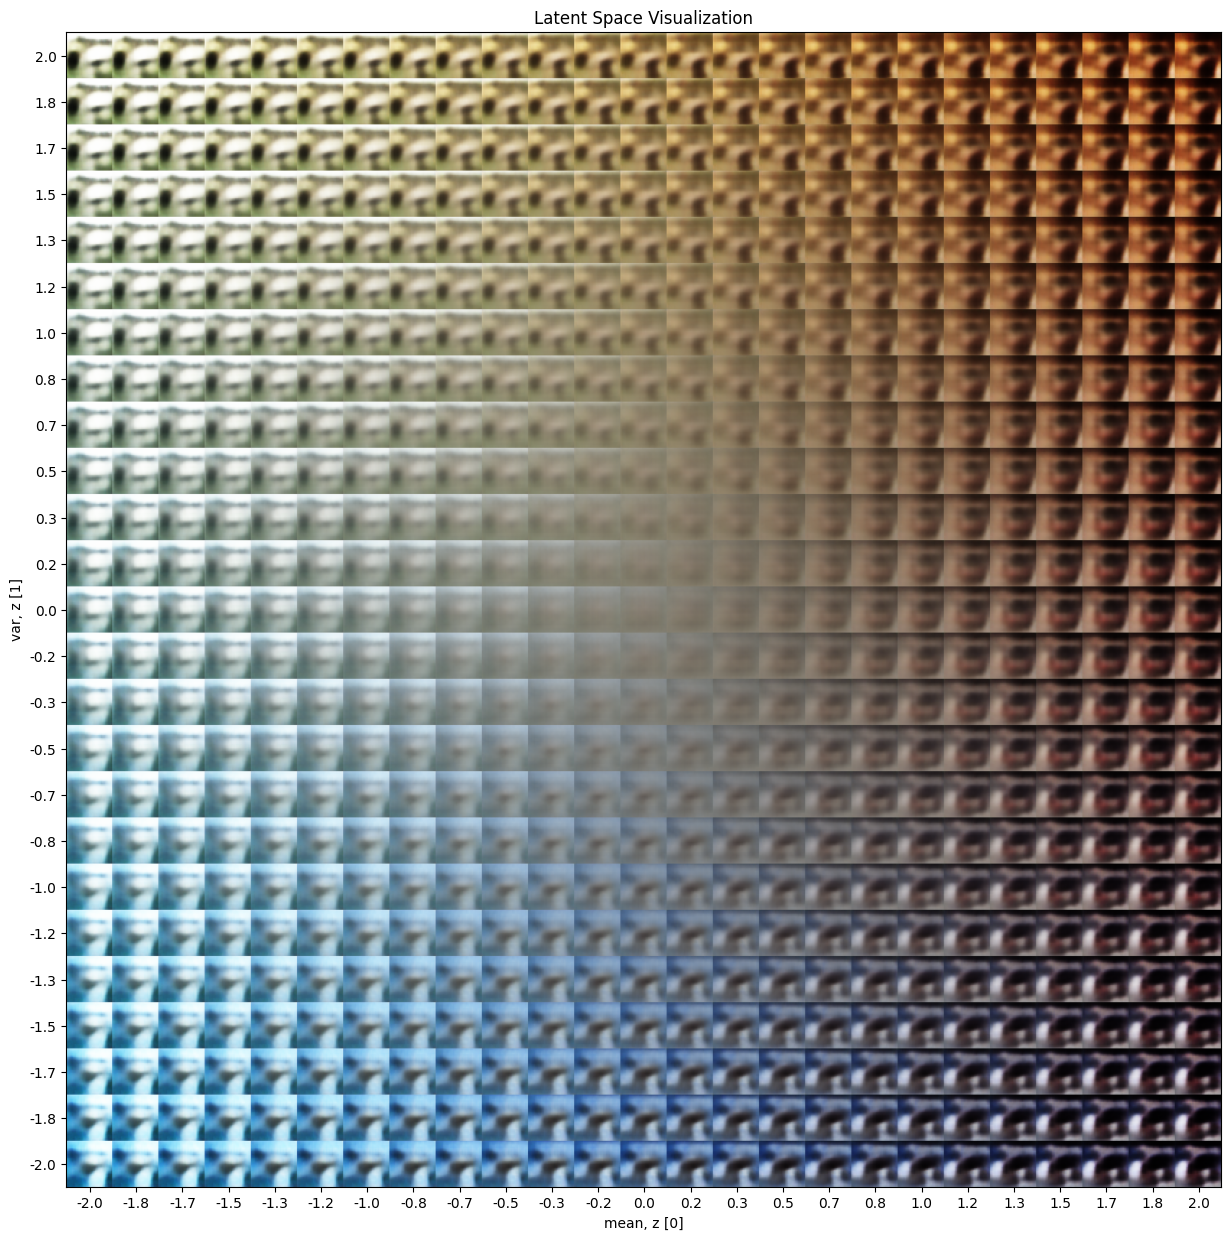

In [ ]:
def plot_latent_space(model, scale=5.0, n=25, digit_size=32, figsize=15):
    # display a n*n 2D manifold of digits
    figure = np.zeros((digit_size * n, digit_size * n, 3))

    # construct a grid
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    # Find the required input size for the decoder:
    required_input_size = 256  # Set this to the correct input size expected by the decoder

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = torch.tensor([[xi, yi]]).float().to(device)
            # Expand z_sample to match the expected input dimensions
            z_sample = z_sample.repeat(1, required_input_size // 2)  # Assuming model expects a larger input
            x_decoded = model.decode(z_sample)
            digit = x_decoded.view(3, digit_size, digit_size).cpu().detach().numpy().transpose(1, 2, 0)
            figure[i * digit_size : (i + 1) * digit_size, j * digit_size : (j + 1) * digit_size, :] = digit

    plt.figure(figsize=(figsize, figsize))
    plt.title('Latent Space Visualization')
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("mean, z [0]")
    plt.ylabel("var, z [1]")
    plt.imshow(figure)
    plt.show()

# Use this function as before:
plot_latent_space(model, scale=2.0)


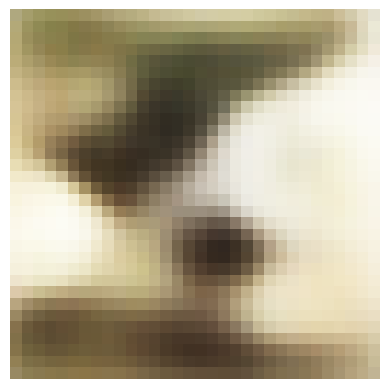

In [13]:
def adjust_brightness(z_sample, brightness_factor):
    return z_sample * brightness_factor

def generate_digit(model, mean, var, brightness_factor=1.0):
    mean = mean.to(device)
    var = var.to(device)
    with torch.no_grad():
        z_sample = torch.randn_like(mean) * var + mean
        z_sample = adjust_brightness(z_sample, brightness_factor)
        x_decoded = model.decoder(z_sample)
    digit = x_decoded.detach().cpu().reshape(3, 32, 32).permute(1, 2, 0)  # Reshape and permute to (32, 32, 3)
    plt.imshow(digit)
    plt.axis('off')
    plt.show()

# Example usage with brightness adjustment
generate_digit(model, mean=torch.zeros(1, 256).to(device), var=torch.ones(1, 256).to(device), brightness_factor=1.5)


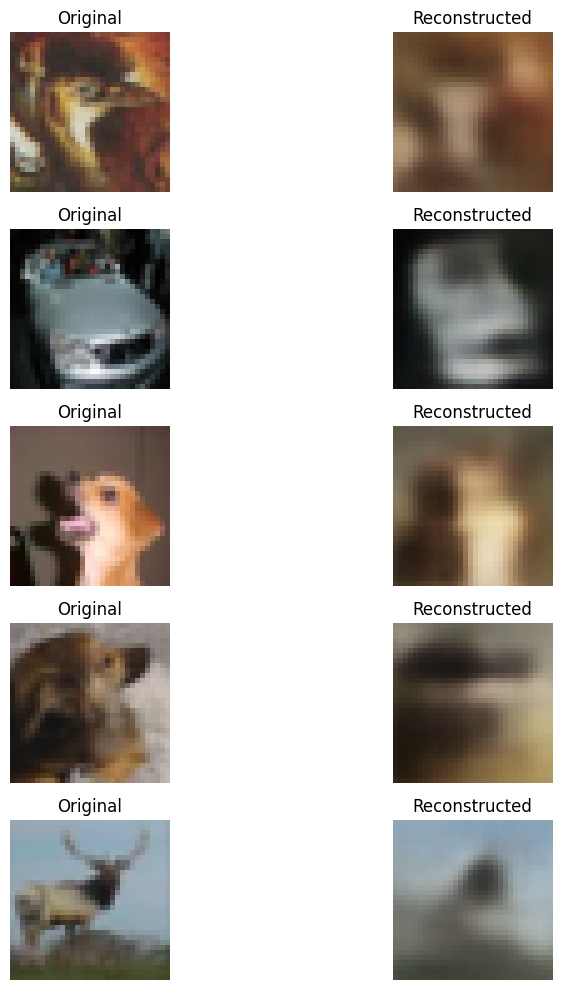

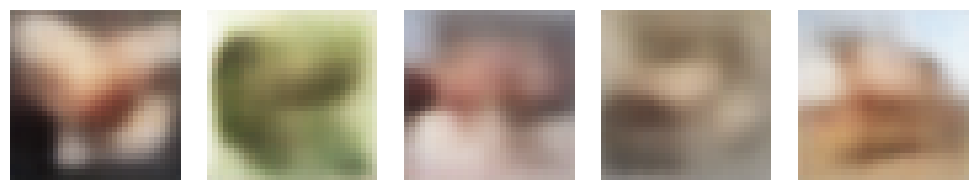

In [26]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_reconstructed_images(model, data_loader, device, num_images=5):
    model.eval()
    with torch.no_grad():
        # Get some random input images from the data loader
        data_iter = iter(data_loader)
        images, _ = next(data_iter)
        images = images[:num_images].to(device)

        # Reconstruct images
        reconstructed_images, _, _ = model(images)

    # Plot original and reconstructed images
    fig, axes = plt.subplots(num_images, 2, figsize=(10, 2 * num_images))
    for i in range(num_images):
        axes[i, 0].imshow(np.transpose(images[i].cpu(), (1, 2, 0)))
        axes[i, 0].set_title("Original")
        axes[i, 0].axis('off')

        axes[i, 1].imshow(np.transpose(reconstructed_images[i].cpu(), (1, 2, 0)))
        axes[i, 1].set_title("Reconstructed")
        axes[i, 1].axis('off')

    plt.tight_layout()
    plt.show()

def visualize_samples_from_latent_space(model, device, latent_dim, num_samples=5):
    model.eval()
    with torch.no_grad():
        # Sample random points from the latent space
        latent_samples = torch.randn(num_samples, latent_dim).to(device)

        # Decode latent samples into data space
        decoded_samples = model.decoder(latent_samples)

    # Plot generated samples
    fig, axes = plt.subplots(1, num_samples, figsize=(2 * num_samples, 2))
    for i in range(num_samples):
        axes[i].imshow(np.transpose(decoded_samples[i].cpu(), (1, 2, 0)))
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

# Usage example:
visualize_reconstructed_images(model, train_loader, device)
visualize_samples_from_latent_space(model, device, latent_dim)
